# Nombre: Cesar Duque
## Web Scrapping a todas las recetas de la pagina allrecipes

Importamos las siguientes libreria para poder hacer web scrapping

In [10]:
from bs4 import BeautifulSoup
import requests
from tqdm import tqdm
import pandas as pd

Cargamos el html que tiene los link de todas las recetas que se encuentran en el siguiente link https://www.allrecipes.com/recipes-a-z-6735880

una vez cargado el html le hacemos un soup para poder encontrar los enlaces gracias a la etiqueta 'a' y finalmente obtenemos los url con la etiqueta 'href'

In [2]:
# Cargar el archivo HTML
with open('codigo.html', 'r', encoding='utf-8') as file:
    soup = BeautifulSoup(file, 'html.parser')

# Encontrar todos los enlaces
links = soup.find_all('a')

# Extraer los href de cada enlace
urls = [link.get('href') for link in links]
urls

['https://www.allrecipes.com/recipes/23070/everyday-cooking/cookware-and-equipment/air-fryer/',
 'https://www.allrecipes.com/recipes/16492/everyday-cooking/special-collections/allrecipes-allstars/',
 'https://www.allrecipes.com/recipes/385/desserts/cakes/angel-food-cake/',
 'https://www.allrecipes.com/recipes/102/appetizers-and-snacks/antipasto/',
 'https://www.allrecipes.com/recipes/76/appetizers-and-snacks/',
 'https://www.allrecipes.com/recipes/788/desserts/pies/apple-pie/',
 'https://www.allrecipes.com/recipes/1333/side-dish/applesauce/',
 'https://www.allrecipes.com/recipes/14913/appetizers-and-snacks/dips-and-spreads/artichoke-dip/',
 'https://www.allrecipes.com/recipes/1537/bread/yeast-bread/bagels/',
 'https://www.allrecipes.com/recipes/1673/side-dish/beans-and-peas/baked-beans/',
 'https://www.allrecipes.com/recipes/343/bread/quick-bread/fruit-bread/banana-bread/',
 'https://www.allrecipes.com/recipes/836/desserts/cookies/bar-cookies/',
 'https://www.allrecipes.com/recipes/200

Dentro de cada link obtenido hay mas recetas ya que estas son categorias y dentro de cada link nos muestran las recetas de los cuales hay que obetener los links.

primero usamos un headers para que no nos detecte que somos bots, y de ahi procedemos hacer un request a todos los links  para obtener el html al cual se le hara un BeautifulSoup y se encontrara todos los links con la etiqueta 'a' y de clase 'comp mntl-card-list-items mntl-document-card mntl-card card card--no-image' y ahi adetro podremos obtener el link el cual se encuentra en la etiqueta 'href' y vamos guardando cada link en la lista link_total usando extend debido a que estamos guardando una lista dentro de otra lista y para no crear una matriz usamos extend para seguir aumentando en solo 1 dimension

In [3]:
headers = {
    "User-Agent":"My Phyton App"
}
link_total = []
for url in tqdm(urls, 'Procesando'):
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    recipe_cards = soup.find_all('a', class_='comp mntl-card-list-items mntl-document-card mntl-card card card--no-image')
    urls = [link.get('href') for link in recipe_cards]
    link_total.extend(urls)
link_total

Procesando: 100%|██████████| 378/378 [02:34<00:00,  2.44it/s]


['https://www.allrecipes.com/air-fryer-quesadillas-recipe-8651442',
 'https://www.allrecipes.com/air-fryer-truffle-polenta-fries-recipe-8643717',
 'https://www.allrecipes.com/air-fryer-firecracker-salmon-bites-recipe-8623119',
 'https://www.allrecipes.com/air-fryer-chicken-bites-recipe-8599352',
 'https://www.allrecipes.com/4-ingredient-air-fryer-pepper-poppers-recipe-8584965',
 'https://www.allrecipes.com/air-fryer-bell-pepper-poppers-recipe-8584648',
 'https://www.allrecipes.com/air-fryer-cinnamon-roll-bites-recipe-8553617',
 'https://www.allrecipes.com/air-fryer-ham-and-cheese-wraps-recipe-8365118',
 'https://www.allrecipes.com/recipe/8537905/air-fryer-buffalo-cauliflower/',
 'https://www.allrecipes.com/air-fryer-honey-mustard-chicken-thighs-recipe-7970816',
 'https://www.allrecipes.com/air-fryer-hearts-of-palm-sticks-recipe-7814346',
 'https://www.allrecipes.com/air-fryer-cheesy-bacon-ranch-french-fries-recipe-7560981',
 'https://www.allrecipes.com/air-fryer-mini-dark-chocolate-cak

importamos la libreria pickel para exportar los links totales ya que al hacer web scrapping  a todos los link tardaria varias horas asi que se usara multiprocesamiento en un script aparte y necesitamos los links para eso

In [79]:
import pickle
with open('link_total.pkl', 'wb') as file:
    pickle.dump(link_total, file)

antes de realizar web scrapping a todos lo links lo haremos con 80 links de prueba.

importamos la libreria numpy y se creara varios arrays para guardar la informacion que se va obtener de cada receta para realizar el dataframe.

recorremos los 80 links con el for, con la ayuda de la libreria tqdm ponemos una barra de cuanto tiempo tardaria y para cada link se le hace un request y obtenemos los datos que necesitamos y los guardamos en los arrays correspondientes usando try catch por si no encuentra unos de los datos y lo llene en vacio y no se detenga el programa por alguna receta que no siga la estructura investigada

Finalmente creamos un dataframe con los datos obetenidos  y sus respectivos links, en este caso solo se uso 80 links debido al tiempo que requiere para completar este proceso y por ultimo eliminamos las filas que contengan alguna de sus columnas vacias

In [96]:
import numpy as np
titulo=[]
descripcion=[]
ingredientes = []
receta = []

for link in tqdm(link_total[:80], 'Procesando'):
    try:
        response = requests.get(link, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        try:
            titulo.append(soup.find('title').text)
        except Exception as e:
            titulo.append(None)
        try:
            descripcion.append(soup.find('p',class_='article-subheading type--dog').text)
        except Exception as e:
            descripcion.append(None)
        try:            
            listas=soup.find_all('li',class_='mm-recipes-structured-ingredients__list-item')
            texto =''
            for lista in listas:
                spans=lista.find_all('span')
                for span in spans:
                    texto += span.text + ' '
                texto += '\n'

            ingredientes.append(texto)
        except Exception as e:
            ingredientes.append(None)

        try:
            parrafos=soup.find_all('p',class_='comp mntl-sc-block mntl-sc-block-html')
            texto = ''
            for parrafo in parrafos:
                texto += parrafo.text + ' '
                texto += '\n'
            receta.append(texto)
        except Exception as e:
            receta.append(None)   

    except Exception as e:
        titulo.append(None)
        descripcion.append(None)
        ingredientes.append(None)
        receta.append(None)

corpus=pd.DataFrame({'Titulo':titulo,'Descripcion':descripcion,'Ingredientes':ingredientes,'Receta':receta,'Link':link_total[:80]})
# Reemplazar cadenas vacías con NaN
corpus.replace('', np.nan, inplace=True)
corpus = corpus.dropna()
corpus

Procesando: 100%|██████████| 80/80 [00:29<00:00,  2.75it/s]


,Titulo,Descripcion,Ingredientes,Receta,Link
0,Air Fryer Quesadillas Recipe,These air fryer quesadillas are golden and cri...,2 flour tortillas \n1/2 cup shredded cheese \n...,Heat tortillas in the microwave until pliable...,https://www.allrecipes.com/air-fryer-quesadill...
1,Air Fryer Truffle Polenta Fries Recipe,"These air fryer truffle polenta fries, flavore...",1 (18 ounce) tube polenta \n1 1/2 tablespoons ...,Preheat an air fryer to 400 degrees F (200 de...,https://www.allrecipes.com/air-fryer-truffle-p...
2,Air Fryer Firecracker Salmon Bites Recipe,These air fryer firecracker salmon bites get a...,1/4 cup balsamic vinegar \n1/4 cup brown sugar...,"Combine balsamic vinegar, brown sugar, oil, s...",https://www.allrecipes.com/air-fryer-firecrack...
3,Air Fryer Chicken Bites Recipe,"These air fryer chicken bites, seasoned with l...","1 pound boneless chicken breasts, \n3 tablesp...",Preheat an air fryer to 350 degrees F (175 de...,https://www.allrecipes.com/air-fryer-chicken-b...
4,4 Ingredient Air Fryer Pepper Poppers Recipe,These 4 ingredient air fryer pepper poppers ha...,"1 bell pepper, any color \n8 ounces cream chee...",Preheat an air fryer to 390 degrees F (199 de...,https://www.allrecipes.com/4-ingredient-air-fr...
...,...,...,...,...,...
75,Granola Cups Recipe,These granola cups are a great grab-and-go bre...,1/4 cup unsalted butter \n1/2 cup maple syrup ...,Place butter and maple syrup in a large bowl ...,https://www.allrecipes.com/granola-cups-recipe...
76,4-Ingredient Hamburger Casserole Recipe,This 4-ingredient hamburger casserole is so co...,"8 ounces pasta \n1 pound ground beef \nsalt, f...",Preheat the oven to 350 degrees F (175 degree...,https://www.allrecipes.com/4-ingredient-hambur...
77,Salmon Caesar Salad Recipe,"This salmon Caesar salad, with Romaine lettuce...",1 (8 ounce) salmon filet \n2 teaspoons oil \n2...,Set a nonstick skillet over medium high heat....,https://www.allrecipes.com/salmon-caesar-salad...
78,New York-Style Crumb Cake Recipe,New York-style crumb cake is known for its mil...,4 cups cake flour \n1 cup brown sugar \n1/2 cu...,Preheat the oven to 350 degrees F (175 degree...,https://www.allrecipes.com/new-york-style-crum...


Para procesar todos los datos se uso multiprocessing usando 12 cores y exportando en formato csv, en la imagen se puede ver el procesamiento que se hizo y cuanto tiempo tardo:

![Screenshot 2024-07-18 034430.png](<attachment:Screenshot 2024-07-18 034430.png>)
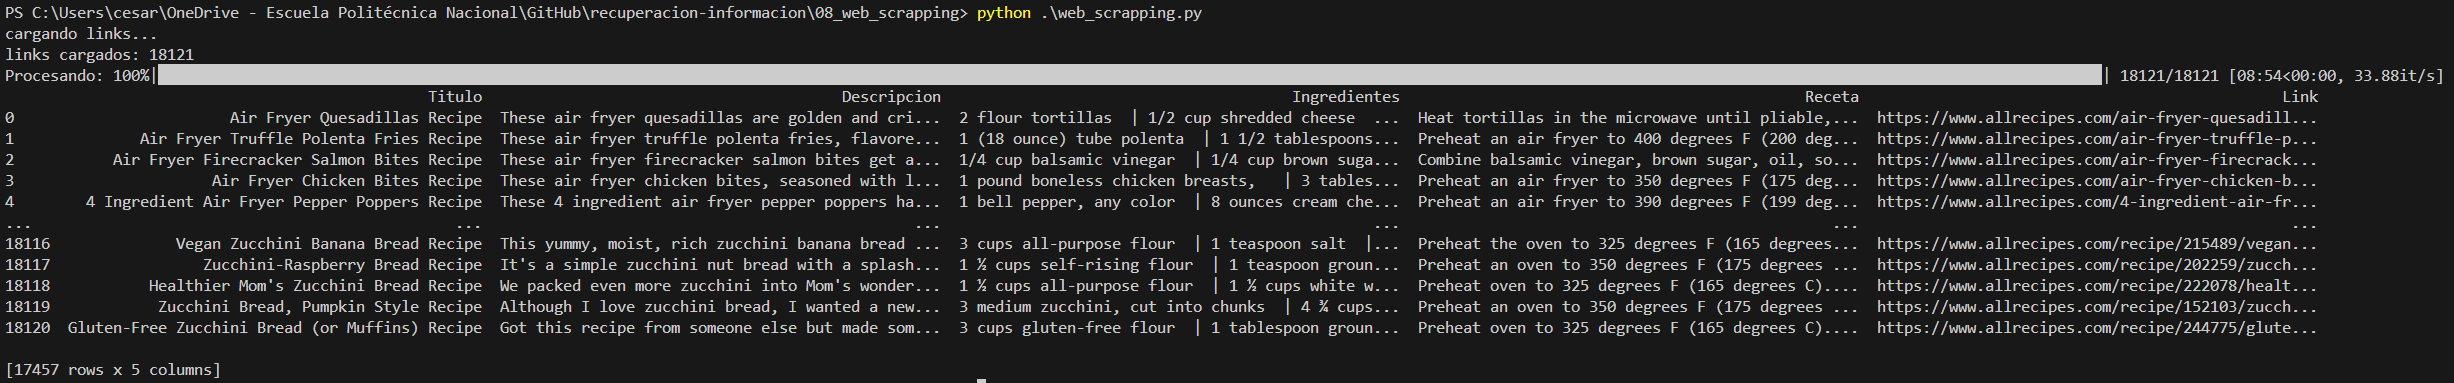

Se carga el csv generado con multipocesamiento:

In [99]:
corpus_total = pd.read_csv('corpus_multiprocessing.csv')
corpus_total

,Titulo,Descripcion,Ingredientes,Receta,Link
0,Air Fryer Quesadillas Recipe,These air fryer quesadillas are golden and cri...,2 flour tortillas | 1/2 cup shredded cheese ...,"Heat tortillas in the microwave until pliable,...",https://www.allrecipes.com/air-fryer-quesadill...
1,Air Fryer Truffle Polenta Fries Recipe,"These air fryer truffle polenta fries, flavore...",1 (18 ounce) tube polenta | 1 1/2 tablespoons...,Preheat an air fryer to 400 degrees F (200 deg...,https://www.allrecipes.com/air-fryer-truffle-p...
2,Air Fryer Firecracker Salmon Bites Recipe,These air fryer firecracker salmon bites get a...,1/4 cup balsamic vinegar | 1/4 cup brown suga...,"Combine balsamic vinegar, brown sugar, oil, so...",https://www.allrecipes.com/air-fryer-firecrack...
3,Air Fryer Chicken Bites Recipe,"These air fryer chicken bites, seasoned with l...","1 pound boneless chicken breasts, | 3 tables...",Preheat an air fryer to 350 degrees F (175 deg...,https://www.allrecipes.com/air-fryer-chicken-b...
4,4 Ingredient Air Fryer Pepper Poppers Recipe,These 4 ingredient air fryer pepper poppers ha...,"1 bell pepper, any color | 8 ounces cream che...",Preheat an air fryer to 390 degrees F (199 deg...,https://www.allrecipes.com/4-ingredient-air-fr...
...,...,...,...,...,...
17452,Vegan Zucchini Banana Bread Recipe,"This yummy, moist, rich zucchini banana bread ...",3 cups all-purpose flour | 1 teaspoon salt |...,Preheat the oven to 325 degrees F (165 degrees...,https://www.allrecipes.com/recipe/215489/vegan...
17453,Zucchini-Raspberry Bread Recipe,It's a simple zucchini nut bread with a splash...,1 ½ cups self-rising flour | 1 teaspoon groun...,Preheat an oven to 350 degrees F (175 degrees ...,https://www.allrecipes.com/recipe/202259/zucch...
17454,Healthier Mom's Zucchini Bread Recipe,We packed even more zucchini into Mom's wonder...,1 ½ cups all-purpose flour | 1 ½ cups white w...,Preheat oven to 325 degrees F (165 degrees C)....,https://www.allrecipes.com/recipe/222078/healt...
17455,"Zucchini Bread, Pumpkin Style Recipe","Although I love zucchini bread, I wanted a new...","3 medium zucchini, cut into chunks | 4 ¾ cups...",Preheat an oven to 350 degrees F (175 degrees ...,https://www.allrecipes.com/recipe/152103/zucch...


Como pudimos ver se obtuvo con exito un data frame de todas la recetas de la pagina con su respectivo titulo, descripcion, ingredientes, receta y su link el cual podria ser usado como un corpues par aun sistema de recuperacion 